## Creating Time Window
Info:

- window size: 20 sec
- sliding step : 1 sec = 50 Hz
- overlapping windows
- size: 1000samples = 20 seconds * 50 Hz  
- every participant has 63000 samples
- each window does

In [1]:
import numpy as np
import pandas as pd

# Load the preprocessed data
data = pd.read_csv('Data/preprocessed_data.csv')
data.head()


,time_stamp,participant,activity,accel_magnitude
0,1.390000e+12,1,walking,15.043465
1,1.390000e+12,1,walking,14.097451
2,1.390000e+12,1,walking,14.744242
3,1.390000e+12,1,walking,13.321392
4,1.390000e+12,1,walking,12.133143


### Overlapping windows with 1-second steps and 20-second window length


In [2]:
# Define window size and step size
window_size = 1000   # 20 seconds * 50 Hz
step_size = 50       # 1 second * 50 Hz

# Initialize a list to hold the windows and their corresponding majority activities
windows = []
activities = []

# Create sliding windows
for start in range(0, len(data) - window_size + 1, step_size):
    end = start + window_size
    window = data.iloc[start:end]
    windows.append(window)
    majority_activity = window['activity'].mode()[0]  # Get the majority activity
    activities.append(majority_activity)

print(f'Total windows created: {len(windows)}')

Total windows created: 12581


In [3]:
# Convert the list of windows and activities into a DataFrame
windowed_data = pd.DataFrame({'window': windows, 'majority_activity': activities})

# Display the first few entries of the windowed data
windowed_data.sample(5)

,window,majority_activity
7923,time_stamp participant activity ac...,jogging
8353,time_stamp participant activity ac...,biking
1242,time_stamp participant activity ...,downstairs
8536,time_stamp participant activity a...,upstairs
12182,time_stamp participant activity ac...,biking


In [4]:
from scipy.stats import skew
from scipy.signal import welch

def extract_features(window, fs=50):
    x = window['accel_magnitude'].values.astype(float)
    features = {}
    features['mean'] = np.mean(x)
    features['std'] = np.std(x)
    features['skewness'] = skew(x)
    features['max'] = np.max(x)
    features['min'] = np.min(x)
    features['range'] = np.max(x) - np.min(x)
    # Welch's method for power spectral density
    f, Pxx = welch(x, fs=fs)
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
    
    # Μπορείς να κρατήσεις όλο το φάσμα ή π.χ. το άθροισμα ή το μέγιστο
    features['psd_sum'] = np.sum(Pxx)
    features['psd_max'] = np.max(Pxx)
    # Αν θέλεις όλο το φάσμα:
    # for i, val in enumerate(Pxx):
    #     features[f'psd_{i}'] = val
    return features

# Εξαγωγή χαρακτηριστικών για όλα τα παράθυρα
feature_list = []
for window in windows:
    feats = extract_features(window)
    feature_list.append(feats)

features_df = pd.DataFrame(feature_list)
features_df['majority_activity'] = activities
features_df.sample(5)

,mean,std,skewness,max,min,range,psd_sum,psd_max,majority_activity
2568,11.207104,4.063313,0.055728,22.207906,2.969941,19.237965,86.548281,16.046712,walking
3845,10.955744,4.101190,0.480173,24.028027,1.925518,22.102509,82.316849,19.342870,walking
1044,10.970816,4.652318,0.468638,26.055201,1.638279,24.416922,107.198170,22.131380,upstairs
3890,11.123187,4.337681,0.524667,24.261811,1.785766,22.476044,94.707473,22.374494,walking
1279,11.370234,4.513660,0.236650,22.976508,3.262457,19.714051,107.343514,22.351727,walking


In [6]:
features_df.sample(5)

,mean,std,skewness,max,min,range,psd_sum,psd_max,majority_activity
1518,10.277786,0.022764,0.027259,10.347652,10.192656,0.154995,0.002509,0.000061,standing
5699,9.405702,0.244800,-2.409287,14.112437,4.221222,9.891215,0.029732,0.000866,sitting
7402,10.683867,4.284040,0.751688,23.527098,1.210142,22.316956,90.286445,14.949394,downstairs
3158,9.440867,0.037392,-0.106278,9.619817,9.265391,0.354426,0.006823,0.000171,sitting
9615,9.736229,1.870210,0.104070,15.602846,4.360548,11.242297,16.300315,4.971381,biking


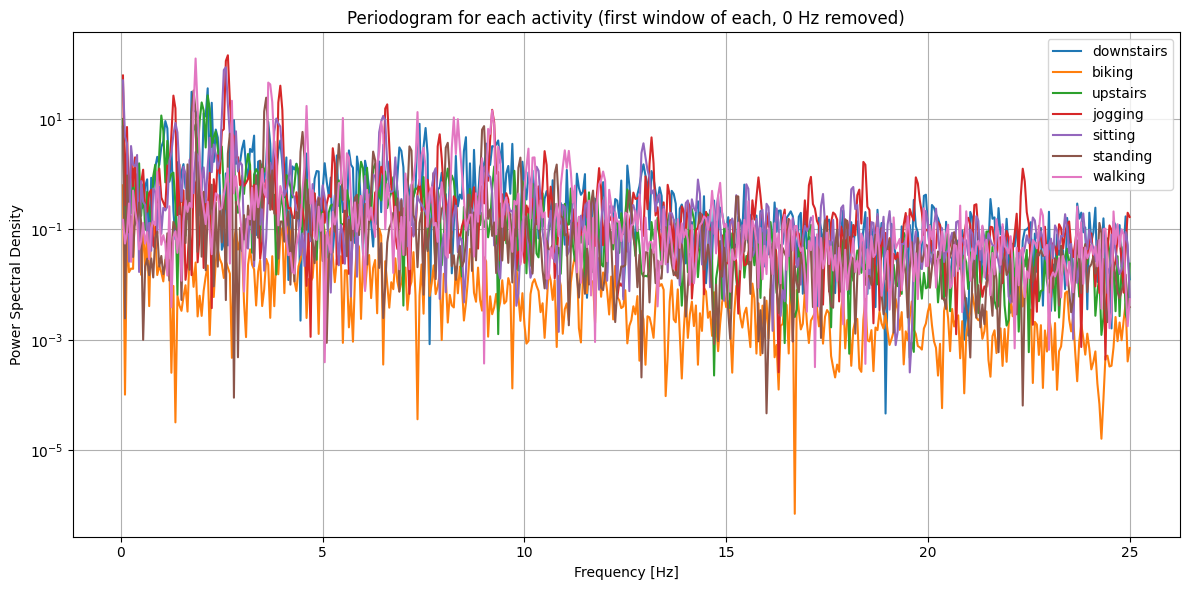

In [7]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt


unique_activities = list(set(activities))
fs = 50  # Sampling frequency

plt.figure(figsize=(12, 6))

for activity in unique_activities:
    # Find indices of windows with the current activity
    activity_indices = [i for i, act in enumerate(activities) if act == activity]
    if activity_indices:
        idx = activity_indices[0]
        window = windows[idx]
        x = window['accel_magnitude'].values.astype(float)
        f, Pxx = periodogram(x, fs=fs)
        # Remove the 0 Hz component
        f = f[1:]
        Pxx = Pxx[1:]
        plt.semilogy(f, Pxx, label=str(activity))
    else:
        print(f"No windows found for activity: {activity}")

plt.title('Periodogram for each activity (first window of each, 0 Hz removed)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

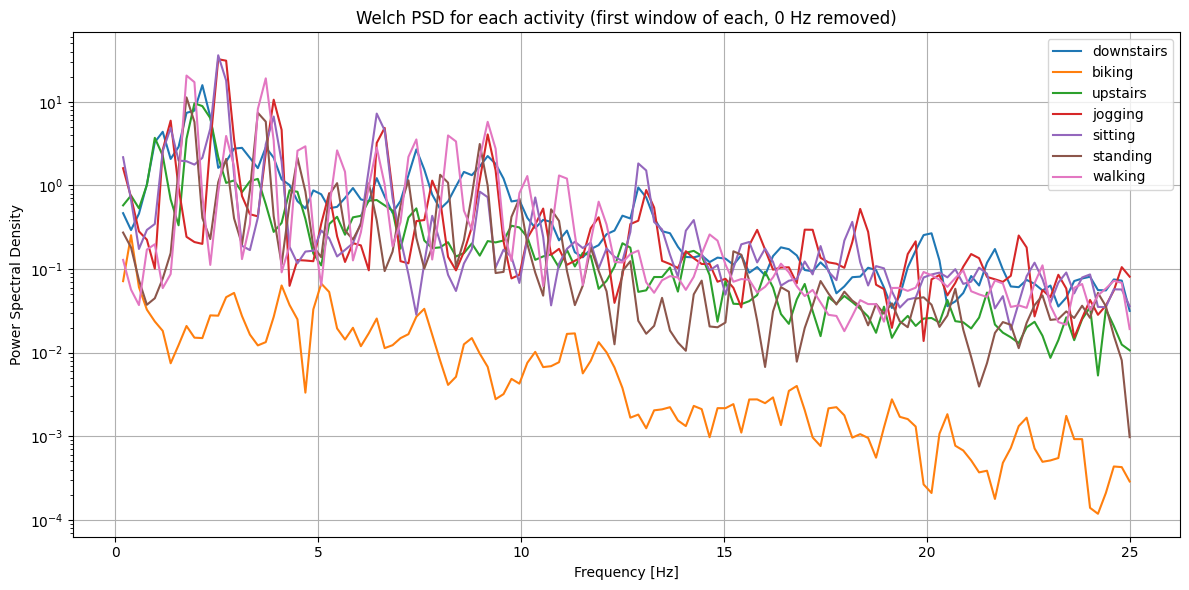

In [8]:
from scipy.signal import welch
import matplotlib.pyplot as plt


unique_activities = list(set(activities))
fs = 50  # Sampling frequency

plt.figure(figsize=(12, 6))

for activity in unique_activities:
    # Find indices of windows with the current activity
    activity_indices = [i for i, act in enumerate(activities) if act == activity]
    if activity_indices:
        idx = activity_indices[0]
        window = windows[idx]
        x = window['accel_magnitude'].values.astype(float)
        f, Pxx = welch(x, fs=fs)
        # Remove the 0 Hz component
        f = f[1:]
        Pxx = Pxx[1:]
        plt.semilogy(f, Pxx, label=str(activity))
    else:
        print(f"No windows found for activity: {activity}")

plt.title('Welch PSD for each activity (first window of each, 0 Hz removed)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Need to decide how this feature to be used

In [9]:
# Save the windowed data to a new CSV file
output_windowed_file_path = 'Data/windowed_data.csv'
windowed_data.to_csv(output_windowed_file_path, index=False)
print(f'Windowed data saved to {output_windowed_file_path}')

Windowed data saved to Data/windowed_data.csv
